# A/B testing for the largest online game with over 7 billion dollars in revenue and 350 million new account registrations per year.
***
Checking the impact on game mechanics of changes made to settings and configurations.
Changes were made incrementally, also for group A changes were available, for group B changes were not.

## Data Cleaning and Preprocessing

In [1]:
import pandas as pd
data = pd.read_csv('data_1.csv')

In [2]:
data.isnull().sum()

player_id                  0
battle_id                  0
dt                         0
player_group               0
in_battle_presence_time    0
damage_dealt               0
kills_made                 0
vehicle_lvl                0
account_created_at         0
dtype: int64

In [3]:
data = data.drop_duplicates()
data = data.dropna(axis=0, how='any')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374217 entries, 0 to 374216
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   player_id                374217 non-null  object
 1   battle_id                374217 non-null  object
 2   dt                       374217 non-null  object
 3   player_group             374217 non-null  object
 4   in_battle_presence_time  374217 non-null  int64 
 5   damage_dealt             374217 non-null  int64 
 6   kills_made               374217 non-null  int64 
 7   vehicle_lvl              374217 non-null  int64 
 8   account_created_at       374217 non-null  object
dtypes: int64(4), object(5)
memory usage: 25.7+ MB


In [5]:
data['dt'] = pd.to_datetime(data['dt'], format='%d.%m.%y', errors='coerce')
data['account_created_at'] = pd.to_datetime(data['account_created_at'], format='%d.%m.%y', errors='coerce')

## Exploratory Data Analysis (EDA)

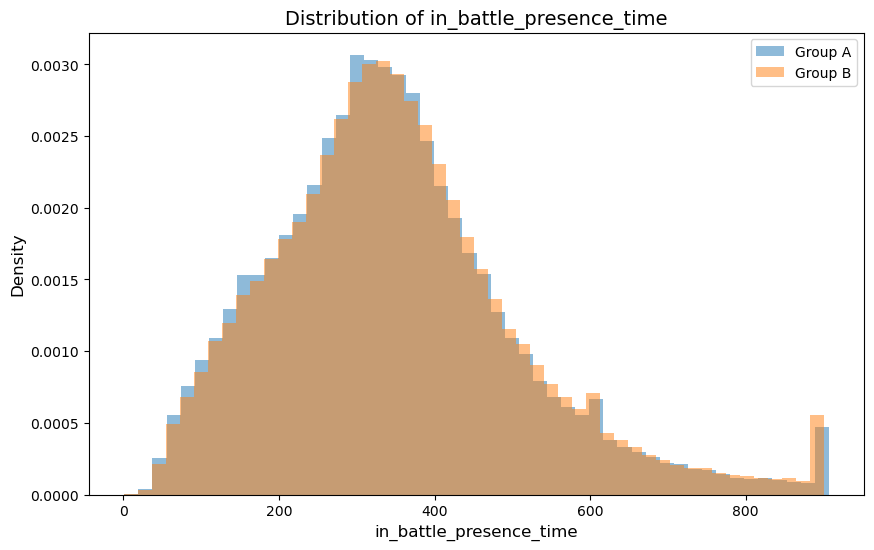

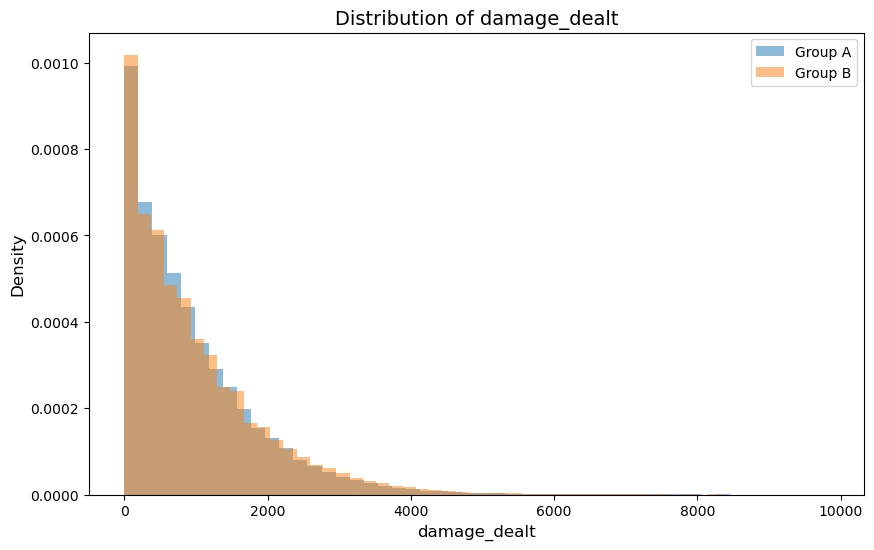

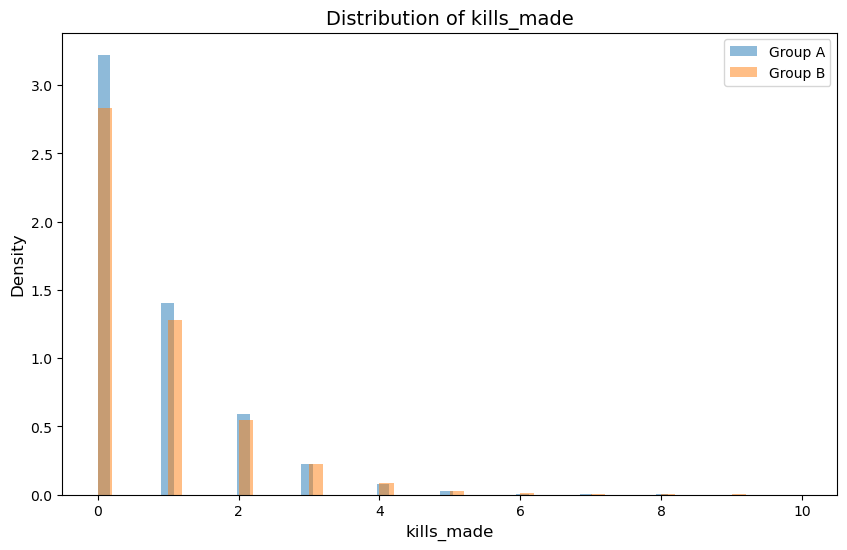

In [6]:
import matplotlib.pyplot as plt

# Split the data by player group
group_a = data[data['player_group'] == 'A']
group_b = data[data['player_group'] == 'B']

# Plot distributions of key metrics
metrics = ['in_battle_presence_time', 'damage_dealt', 'kills_made']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.hist(group_a[metric], bins=50, alpha=0.5, label='Group A', density=True)
    plt.hist(group_b[metric], bins=50, alpha=0.5, label='Group B', density=True)
    plt.title(f'Distribution of {metric}', fontsize=14)
    plt.xlabel(metric, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.show()

In [7]:
data['damage_per_minute'] = data['damage_dealt'] / (data['in_battle_presence_time'] / 60)
data['kills_per_minute'] = data['kills_made'] / (data['in_battle_presence_time'] / 60)
data['damage_per_vehicle_level'] = data['damage_dealt'] / data['vehicle_lvl']
data['kills_per_level'] = data['kills_made'] / data['vehicle_lvl']

In [8]:
date_summary = {
    "Min Date (dt)": data['dt'].min(),
    "Max Date (dt)": data['dt'].max(),
    "Min Account Created At": data['account_created_at'].min(),
    "Max Account Created At": data['account_created_at'].max(),
}

numerical_columns = ['in_battle_presence_time',
                     'damage_dealt',
                     'kills_made',
                     'vehicle_lvl',
                     'damage_per_minute',
                     'kills_per_minute',
                     'damage_per_vehicle_level',
                     'kills_per_level']

from IPython.display import display
display(date_summary)
display(data[numerical_columns].describe())

{'Min Date (dt)': Timestamp('2022-10-11 00:00:00'),
 'Max Date (dt)': Timestamp('2022-11-29 00:00:00'),
 'Min Account Created At': Timestamp('2011-01-22 00:00:00'),
 'Max Account Created At': Timestamp('2022-11-29 00:00:00')}

,in_battle_presence_time,damage_dealt,kills_made,vehicle_lvl,damage_per_minute,kills_per_minute,damage_per_vehicle_level,kills_per_level
count,374217.000000,374217.000000,374217.000000,374217.000000,374217.000000,374217.000000,374217.000000,374217.000000
mean,350.607273,956.662789,0.701817,7.151789,169.320916,0.113620,128.738222,0.112184
std,160.535720,923.346416,1.023907,2.032247,157.998899,0.168614,110.414594,0.206182
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,243.000000,277.000000,0.000000,6.000000,54.143426,0.000000,45.000000,0.000000
50%,335.000000,711.000000,0.000000,8.000000,130.000000,0.000000,104.625000,0.000000
75%,433.000000,1381.000000,1.000000,9.000000,241.383285,0.190476,186.750000,0.166667
max,907.000000,9835.000000,10.000000,10.000000,1919.520000,2.238806,1291.000000,7.000000


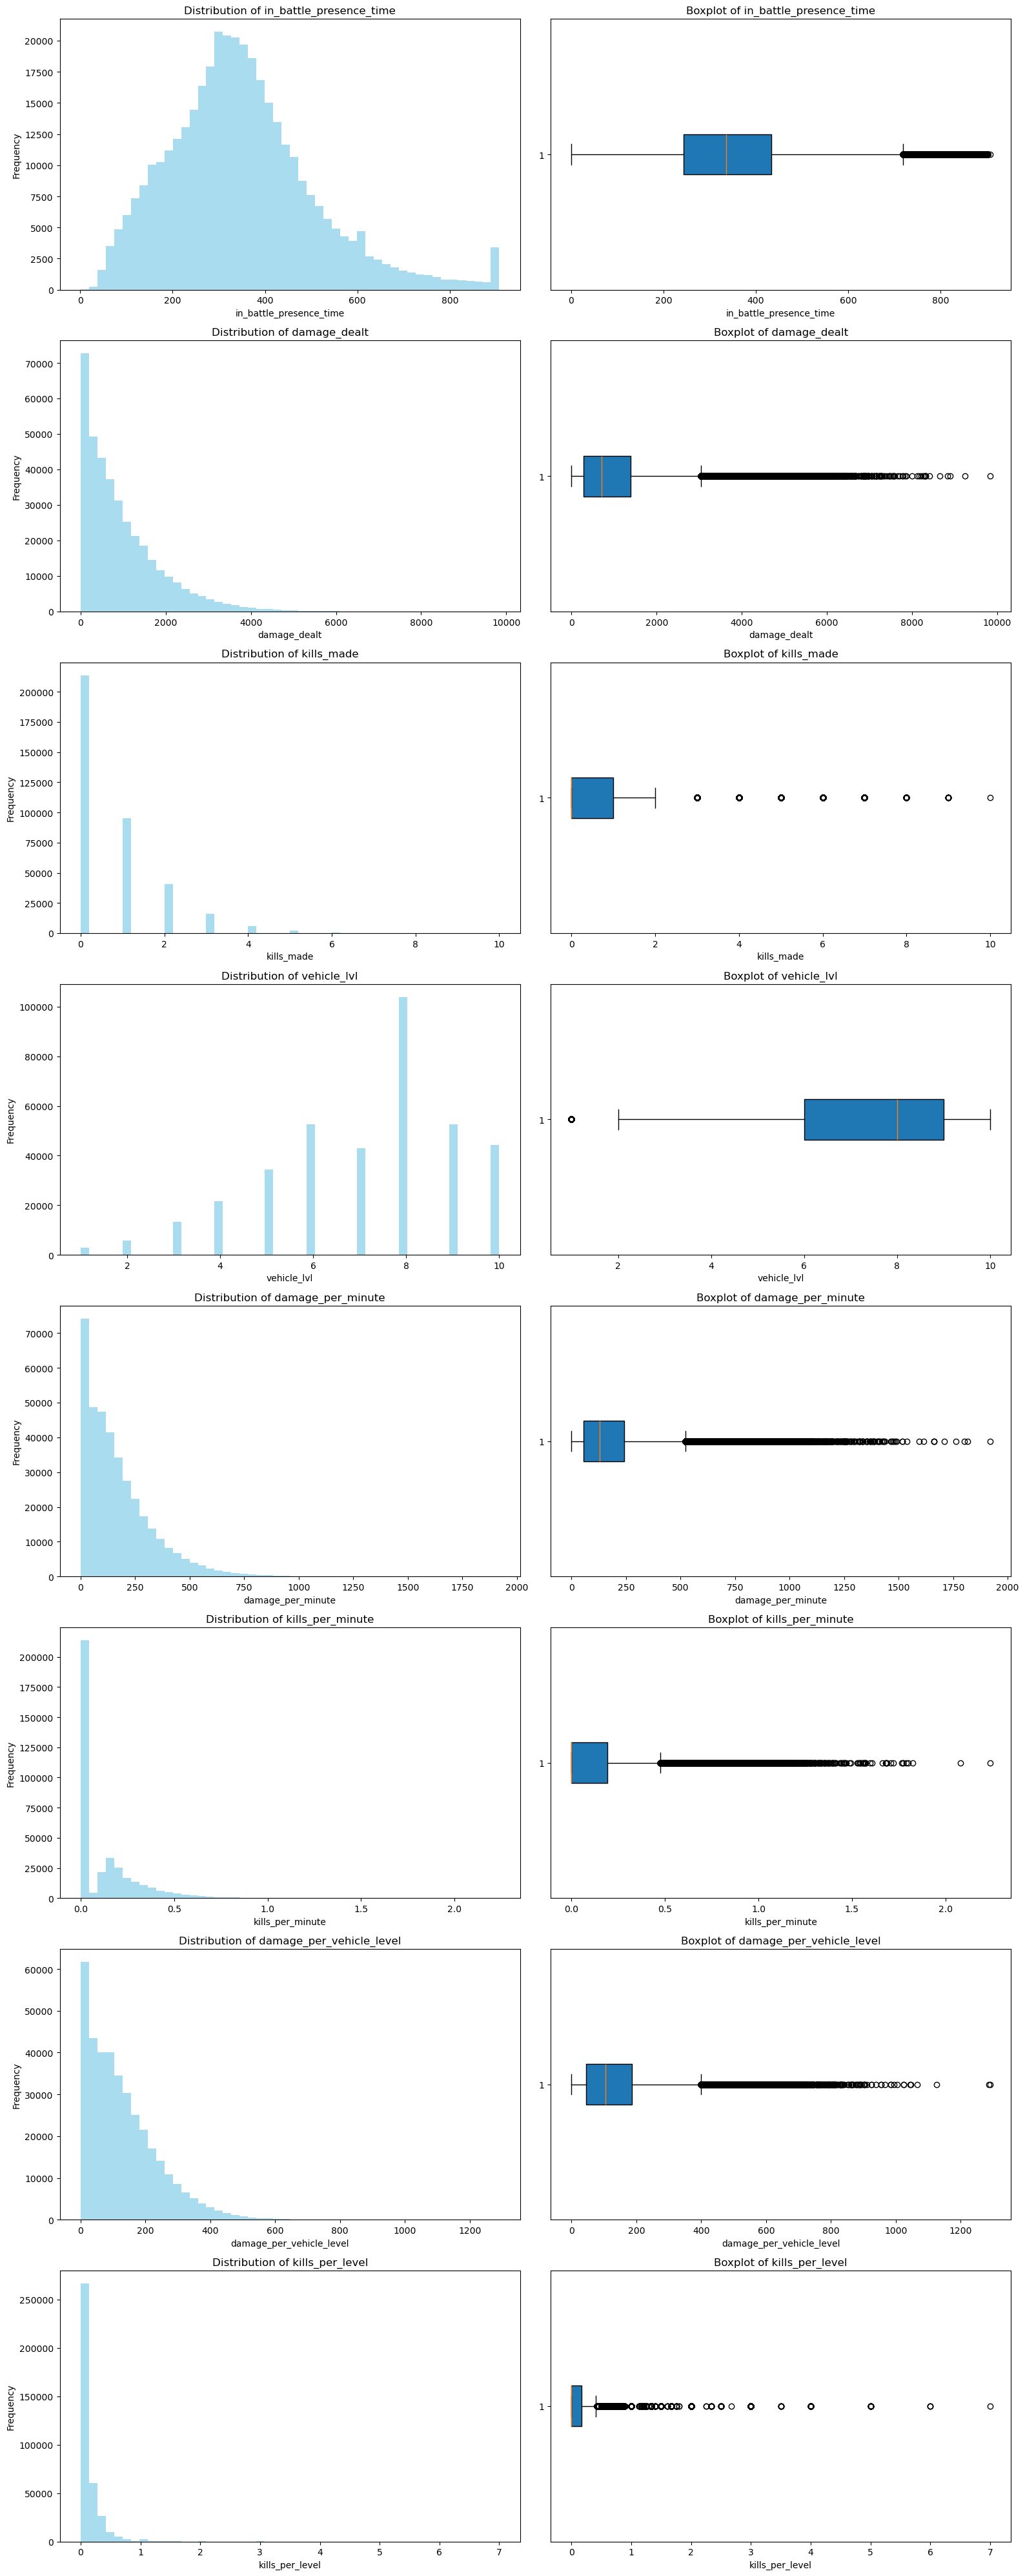

In [9]:
import numpy as np

n_cols = 2
n_rows = len(numerical_columns)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))

if n_rows == 1:
    axes = np.array([axes])

for i, col in enumerate(numerical_columns):
    try:
        axes[i, 0].hist(data[col], bins=50, color='skyblue', alpha=0.7)
        axes[i, 0].set_title(f'Distribution of {col}')
        axes[i, 0].set_xlabel(col)
        axes[i, 0].set_ylabel('Frequency')

        axes[i, 1].boxplot(data[col], vert=False, patch_artist=True)
        axes[i, 1].set_title(f'Boxplot of {col}')
        axes[i, 1].set_xlabel(col)

    except Exception as e:
        print(f"Error processing column {col}: {e}")

plt.tight_layout()
plt.show()

In [10]:
# Define update period for group A
update_start = pd.to_datetime('2022-10-27')
update_end = pd.to_datetime('2022-11-29')

# Split data into groups A and B
group_a = data[data['player_group'] == 'A']
group_b = data[data['player_group'] == 'B']

# Further split group A into pre-update and post-update
group_a_pre = group_a[group_a['dt'] < update_start]
group_a_post = group_a[(group_a['dt'] >= update_start) & (group_a['dt'] <= update_end)]
group_b_pre = group_b[group_b['dt'] < update_start]
group_b_post = group_b[(group_b['dt'] >= update_start) & (group_b['dt'] <= update_end)]

# Summary of group sizes
group_sizes = {
    "Group A Total": group_a.shape[0],
    "Group A Pre-Update": group_a_pre.shape[0],
    "Group A Post-Update": group_a_post.shape[0],
    "Group B Total": group_b.shape[0],
    "Group B Pre-Update": group_b_pre.shape[0],
    "Group B Post-Update": group_b_post.shape[0],
}

group_sizes

{'Group A Total': 134322,
 'Group A Pre-Update': 38680,
 'Group A Post-Update': 95642,
 'Group B Total': 239895,
 'Group B Pre-Update': 66766,
 'Group B Post-Update': 173129}

## Statistical Analysis

### Time-Based Analytics of Player Metrics

In [11]:
data['update_period'] = data['dt'] >= pd.Timestamp('2022-10-27')

# Calculate average metrics before and after the update for each group
time_analysis = data.groupby(['player_group', 'update_period']).agg(
    avg_presence_time=('in_battle_presence_time', 'mean'),
    avg_damage_dealt=('damage_dealt', 'mean'),
    avg_kills_made=('kills_made', 'mean')
).reset_index()

display(time_analysis)

,player_group,update_period,avg_presence_time,avg_damage_dealt,avg_kills_made
0,A,False,347.517166,941.808868,0.682291
1,A,True,346.802608,926.655005,0.674515
2,B,False,354.225130,987.811101,0.719992
3,B,True,352.004274,964.546540,0.714254


### T-Test for Pre- and Post-Update Comparison

In [12]:
from scipy.stats import ttest_ind

test_results = []
for metric in numerical_columns:
    t_stat_a, p_val_a = ttest_ind(group_a_pre[metric], group_a_post[metric], equal_var=False)
    t_stat_b, p_val_b = ttest_ind(group_b_pre[metric], group_b_post[metric], equal_var=False)
    test_results.append({
        'Metric': metric,
        'Group A (Pre vs Post) t-stat': t_stat_a,
        'Group A (Pre vs Post) p-value': p_val_a,
        'Group B (Pre vs Post) t-stat': t_stat_b,
        'Group B (Pre vs Post) p-value': p_val_b
    })

display(pd.DataFrame(test_results))

,Metric,Group A (Pre vs Post) t-stat,Group A (Pre vs Post) p-value,Group B (Pre vs Post) t-stat,Group B (Pre vs Post) p-value
0,in_battle_presence_time,0.743918,0.456929,3.024850,2.488083e-03
1,damage_dealt,2.816592,0.004855,5.399808,6.683888e-08
2,kills_made,1.303042,0.192565,1.212597,2.252865e-01
3,vehicle_lvl,0.313707,0.753745,0.836669,4.027805e-01
4,damage_per_minute,4.063722,0.000048,4.423517,9.719205e-06
5,kills_per_minute,1.686402,0.091723,-0.114944,9.084901e-01
6,damage_per_vehicle_level,4.133312,0.000036,4.588104,4.477381e-06
7,kills_per_level,4.204792,0.000026,-0.786894,4.313456e-01


	Group A:
	    •	The change in average damage dealt is statistically significant.
	    •	Changes in in-battle presence time and kills made are not statistically significant.

	Group B:
	    •	Both in-battle presence time and damage dealt show statistically significant changes.
	    •	The change in kills made is not statistically significant.

### A/B testing to evaluate the impact of the update on Group A vs. Group B

In [13]:
ab_test_results = []
for metric in numerical_columns:
    t_stat_ab, p_val_ab = ttest_ind(group_a_post[metric], group_b_post[metric], equal_var=False)
    ab_test_results.append({
        'Metric': metric,
        'Group A vs Group B (Post-Update) t-stat': t_stat_ab,
        'Group A vs Group B (Post-Update) p-value': p_val_ab
    })

display(pd.DataFrame(ab_test_results))

,Metric,Group A vs Group B (Post-Update) t-stat,Group A vs Group B (Post-Update) p-value
0,in_battle_presence_time,-8.059276,7.716939e-16
1,damage_dealt,-10.353903,4.075330e-25
2,kills_made,-9.715903,2.608588e-22
3,vehicle_lvl,2.254859,2.414329e-02
4,damage_per_minute,-3.894004,9.863520e-05
5,kills_per_minute,-6.260480,3.845747e-10
6,damage_per_vehicle_level,-11.053715,2.142812e-28
7,kills_per_level,-6.197229,5.757857e-10


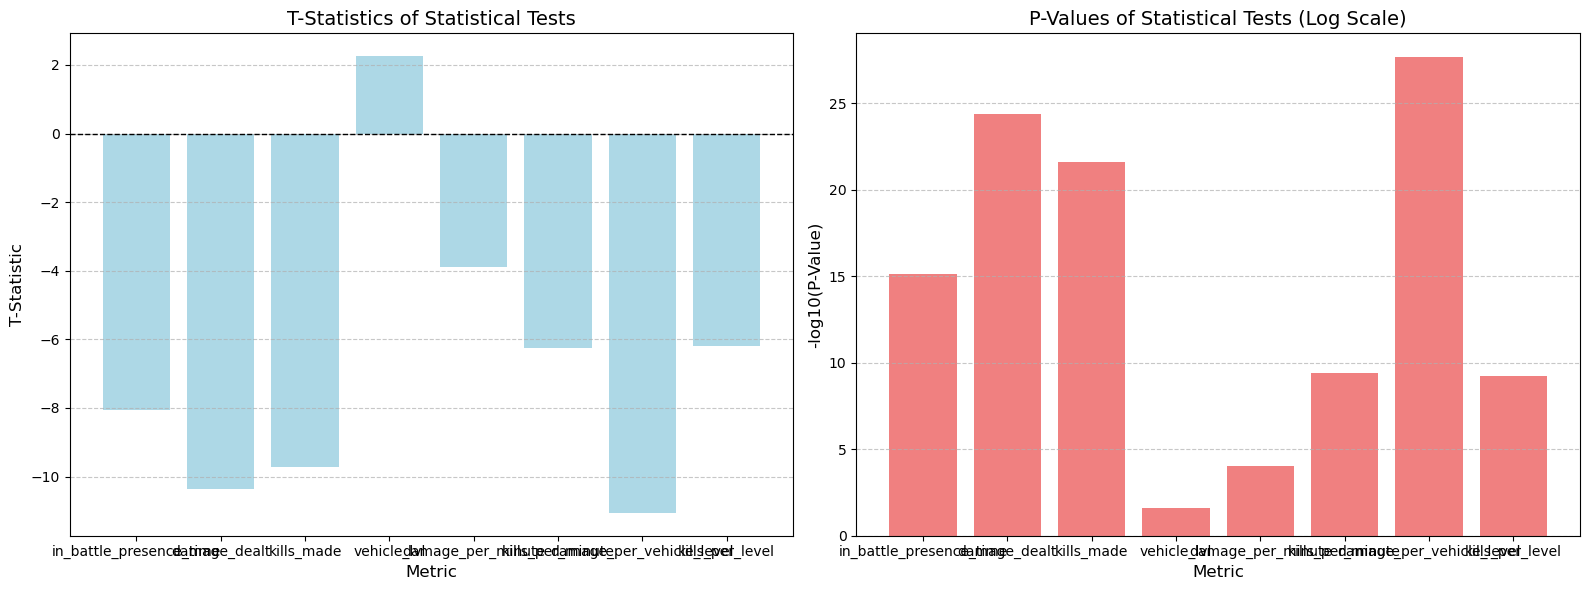

In [14]:
results_ab = pd.DataFrame(ab_test_results)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# T-statistics bar chart
axes[0].bar(results_ab['Metric'], results_ab['Group A vs Group B (Post-Update) t-stat'], color='lightblue')
axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[0].set_title('T-Statistics of Statistical Tests', fontsize=14)
axes[0].set_ylabel('T-Statistic', fontsize=12)
axes[0].set_xlabel('Metric', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# P-values bar chart (log scale for better visualization)
log_p_values = -1 * results_ab['Group A vs Group B (Post-Update) p-value'].apply(lambda x: np.log10(x))
axes[1].bar(results_ab['Metric'], log_p_values, color='lightcoral')
axes[1].set_title('P-Values of Statistical Tests (Log Scale)', fontsize=14)
axes[1].set_ylabel('-log10(P-Value)', fontsize=12)
axes[1].set_xlabel('Metric', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()